# 11. Arrests - relation to other variables

Here I will try to get a clearer view of the arrests, by comparing it to the other variables available. For example, how does the racial composition of a region influences the amount of arrests that will happen in that region? A specific programming problem will appear here, that is, how can we efficiently (and accurately enough) get counts of points in a certain area.

# Load/preprocess data

In [24]:
import geopandas
import matplotlib.pyplot
import numpy
import pandas
import shapely
import statsmodels.api

from cpe_help import Department, util

In [2]:
%matplotlib inline

In [3]:
dept = Department('49-00033')
dept

Department('49-00033')

Load clean data:

In [4]:
precincts = dept.load_police_precincts()
tracts = dept.load_census_tracts()
bgs = dept.load_block_groups()

Load arrests:

In [5]:
raw_arrests = pandas.read_csv(dept.external_dir / '49-00033_Arrests_2015.csv', low_memory=False)
raw_arrests.head()

,INCIDENT_DATE,INCIDENT_TIME,INCIDENT_UNIQUE_IDENTIFIER,LOCATION_DISTRICT,LOCATION_TYPE,UNKNOWN_FIELD_TYPE,SUBJECT_AGE,SUBJECT_GENDER,SUBJECT_RACE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON,UNKNOWN_FIELD_TYPE.2,CHARGE,CHARGE_DESCRIPTION,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,CROSS_STREET,LOCATION_LATITUDE,LOCATION_LONGITUDE
0,ARST DATE,TIME,RPT_ID,AREA,AREA_DESC,RD,AGE,SEX_CD,DESCENT_CD,CHRG_GRP_CD,GRP_DESC,ARST_TYP_CD,CHARGE,CHRG_DESC,LOCATION,CRSST,Location Lat,Location Lon
1,12/31/15 0:00,2345,4538991,14,Pacific,1435,43,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,3500 MCLAUGHLIN AV,NaN,34.0141,-118.4288
2,12/31/15 0:00,2330,4538996,1,Central,101,27,M,W,4,Aggravated Assault,F,273.5(A)PC,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,900 FIGUEROA TR,NaN,34.0663,-118.2441
3,12/31/15 0:00,2320,4539142,6,Hollywood,646,31,M,W,16,Narcotic Drug Laws,M,11350(A)HS,POSSESSION OF CONTROLLED SUBSTANCE,6300 HOLLYWOOD BL,NaN,34.1016,-118.3267
4,12/31/15 0:00,2319,4538947,21,Topanga,2189,28,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,VENTURA FY,WINNETKA,34.1723,-118.5709


In [6]:
variables = pandas.Series(raw_arrests.columns, index=raw_arrests.loc[0])
arrests = raw_arrests.loc[1:].copy()

# process date and drop time
arrests['INCIDENT_DATE'] = pandas.to_datetime(
    arrests['INCIDENT_DATE'], format='%m/%d/%y %H:%M')
arrests = arrests.drop('INCIDENT_TIME', axis=1)

# convert dtypes
numeric_columns = [
    'LOCATION_LATITUDE',
    'LOCATION_LONGITUDE',
]
arrests[numeric_columns] = arrests[numeric_columns].apply(pandas.to_numeric)

# drop entries where lat/lon is unknown
# (5.32% of the entries)
# (could have retrieved approximate lat/lon from address)
arrests = arrests[
    (arrests['LOCATION_LATITUDE'] != 0) &
    (arrests['LOCATION_LONGITUDE'] != 0)
]

# generate points from location
points = [shapely.geometry.Point(x, y)
          for x, y in zip(
              arrests['LOCATION_LONGITUDE'], arrests['LOCATION_LATITUDE'])]

# convert to GeoDataFrame
arrests = geopandas.GeoDataFrame(
    arrests,
    geometry=points,
    crs=util.crs.epsg4326,
)
arrests = arrests.to_crs(precincts.crs)

# select single sample
arrests_all = arrests.copy()
arrests = arrests.sample(10000, random_state=1)

Only use intersecting regions:

In [7]:
region = precincts.unary_union

# crs are already the same
arrests = arrests[arrests.intersects(region)]
tracts = tracts[tracts.intersects(region)]
bgs = bgs[bgs.intersects(region)]

Project into Albers equal-area:

In [8]:
proj = util.crs.equal_area_from_geodf(tracts)

arrests = arrests.to_crs(proj)
precincts = precincts.to_crs(proj)
tracts = tracts.to_crs(proj)
bgs = bgs.to_crs(proj)

Check results:

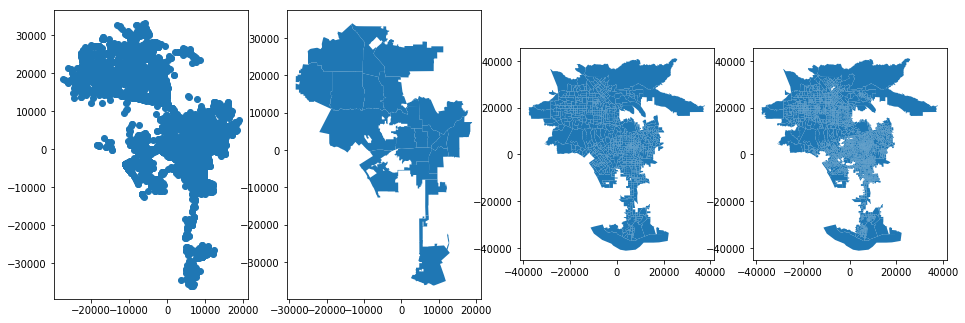

In [9]:
fig, axes = matplotlib.pyplot.subplots(ncols=4, figsize=(16, 12))

for ax in axes:
    ax.set_aspect('equal')
    
arrests.plot(ax=axes[0])
precincts.plot(ax=axes[1])
tracts.plot(ax=axes[2])
bgs.plot(ax=axes[3]);

# Prepare data (for model)

We are gonna only use BGs that are within the police precincts.

In [10]:
bgs = bgs[bgs.within(precincts.unary_union)]

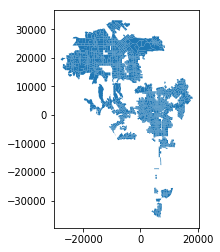

In [11]:
bgs.plot()

Some BGs have almost no people. Let's drop those entries.

In [12]:
bgs = bgs[bgs['TOTAL_POPULATION'] > 150]
bgs = bgs[bgs['POVERTY_TOTAL'] > 100]

Our model is gonna work with ratios instead of absolute values.

In [13]:
race_other = bgs[['RACE_NH_INDIAN', 'RACE_NH_HAWAIIAN', 'RACE_NH_OTHER', 'RACE_NH_MULTIRACIAL']].sum(axis=1)
df = pandas.DataFrame({
    'SEX_FEMALE': bgs['SEX_FEMALE'] / bgs['SEX_TOTAL'],
    'RACE_BLACK': bgs['RACE_NH_BLACK'] / bgs['RACE_TOTAL'],
    'RACE_ASIAN': bgs['RACE_NH_ASIAN'] / bgs['RACE_TOTAL'],
    'RACE_HISPANIC': bgs['RACE_HISPANIC'] / bgs['RACE_TOTAL'],
    'RACE_OTHER': race_other / bgs['RACE_TOTAL'],
    'POVERTY_BPL': bgs['POVERTY_BPL'] / bgs['POVERTY_TOTAL'],
    'EMPLOYMENT_UNEMPLOYED': bgs['EMPLOYMENT_UNEMPLOYED'] / bgs['EMPLOYMENT_TOTAL'],
})
df.head()

,SEX_FEMALE,RACE_BLACK,RACE_ASIAN,RACE_HISPANIC,RACE_OTHER,POVERTY_BPL,EMPLOYMENT_UNEMPLOYED
8,0.369019,0.001421,0.102321,0.055898,0.021317,0.150166,0.075168
125,0.527730,0.049171,0.093196,0.247570,0.088050,0.113779,0.053283
126,0.549724,0.112339,0.078269,0.027624,0.035912,0.099448,0.036364
127,0.537874,0.000000,0.534691,0.399109,0.029281,0.116486,0.071207
128,0.487387,0.053153,0.445495,0.340090,0.014414,0.253604,0.052676


And, we need the crime count for each BG:

In [14]:
%%time

points = [(p, p.x, p.y) for p in arrests.geometry]

result = {}
for ix, bg in bgs.geometry.iteritems():
    bounds = bg.bounds
    xmin, ymin, xmax, ymax = bounds
    
    count = 0
    for point, x, y in points:
        if x < xmin:
            continue
        if y < ymin:
            continue
        if x > xmax:
            continue
        if y > ymax:
            continue
        if bg.contains(point):
            count += 1
            
    result[ix] = count

CPU times: user 5.76 s, sys: 0 ns, total: 5.76 s
Wall time: 5.78 s


In [15]:
sum(result.values())

7898

In [16]:
arrests.shape[0]

9857

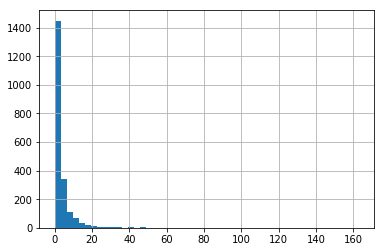

In [17]:
arrest_count = pandas.Series(
    data=list(result.values()),
    index=list(result.keys()),
)
arrest_count.hist(bins=50);

Now we can define our inputs and outputs.

In [18]:
inputs = df.copy()
inputs = inputs * 100  # use percentage values
inputs = statsmodels.api.add_constant(inputs)

outputs = arrest_count / (bgs['TOTAL_POPULATION'] / 1000)
outputs.name = 'ARREST_RATIO'

In [19]:
inputs.head()

,const,SEX_FEMALE,RACE_BLACK,RACE_ASIAN,RACE_HISPANIC,RACE_OTHER,POVERTY_BPL,EMPLOYMENT_UNEMPLOYED
8,1.0,36.901942,0.142113,10.232117,5.589768,2.131691,15.016580,7.516779
125,1.0,52.773013,4.917095,9.319611,24.757004,8.805031,11.377930,5.328259
126,1.0,54.972376,11.233886,7.826888,2.762431,3.591160,9.944751,3.636364
127,1.0,53.787397,0.000000,53.469128,39.910885,2.928071,11.648631,7.120743
128,1.0,48.738739,5.315315,44.549550,34.009009,1.441441,25.360360,5.267559


In [20]:
outputs.head()

8      2.842255
125    2.858776
126    0.000000
127    0.000000
128    0.450450
Name: ARREST_RATIO, dtype: float64

# Create model

Now let's create a model and check if the results are significant.

In [21]:
results = statsmodels.api.OLS(outputs, inputs).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ARREST_RATIO   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     20.92
Date:                Fri, 16 Nov 2018   Prob (F-statistic):           2.28e-27
Time:                        15:09:51   Log-Likelihood:                -7137.3
No. Observations:                2081   AIC:                         1.429e+04
Df Residuals:                    2073   BIC:                         1.434e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    15.2089      1.591      9.557      0.000      12.088      18.330
SEX_FEMALE               -0.2555      0.029     -8.877      0.000      -0.312      -0.199
RACE_BLACK                0.0172      0.013      1.337      0.181      -0.008       0.042
RACE_ASIAN               -0.0168      0.015     -1.143      0.253      -0.046       0.012
RACE_HISPANIC            -0.0369      0.008     -4.800      0.000      -0.052      -0.022
RACE_OTHER               -0.0510      0.055     -0.926      0.354      -0.159       0.057
POVERTY_BPL               0.0875      0.014      6.373      0.000       0.061       0.114
EMPLOYMENT_UNEMPLOYED     0.0606      0.032      1.905      0.057      -0.002       0.123
==============================================================================
Omnibus:                     3570.867   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3409398.531
Skew:                          11.549   Prob(JB):                         0.00
Kurtosis:                     199.944   Cond. No.                         760.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model is pretty weak, having an adjusted R-squared of only 0.063. However, it is a significative model, and the coefficients show a significant relation. BGs with bigger poverty or unemployment percentages are more prone the arrests. BGs with a bigger amount of hispanic people or of women are less prone to arrests.

Below I will try a binomial regression.

In [68]:
# generate inputs
race_other = bgs[['RACE_NH_INDIAN', 'RACE_NH_HAWAIIAN', 'RACE_NH_OTHER', 'RACE_NH_MULTIRACIAL']].sum(axis=1)
inputs = pandas.DataFrame({
    'SEX_FEMALE': bgs['SEX_FEMALE'] / bgs['SEX_TOTAL'],
    'RACE_BLACK': bgs['RACE_NH_BLACK'] / bgs['RACE_TOTAL'],
    'RACE_ASIAN': bgs['RACE_NH_ASIAN'] / bgs['RACE_TOTAL'],
    'RACE_HISPANIC': bgs['RACE_HISPANIC'] / bgs['RACE_TOTAL'],
    'RACE_OTHER': race_other / bgs['RACE_TOTAL'],
    'POVERTY_BPL': bgs['POVERTY_BPL'] / bgs['POVERTY_TOTAL'],
    'EMPLOYMENT_UNEMPLOYED': bgs['EMPLOYMENT_UNEMPLOYED'] / bgs['EMPLOYMENT_TOTAL'],
})
inputs = statsmodels.api.add_constant(inputs)

# generate outputs
outputs = pandas.DataFrame({
    'ARREST_COUNT': arrest_count,
    'NOT_ARREST_COUNT': bgs['TOTAL_POPULATION'] - arrest_count,
})

# create model
results = statsmodels.api.GLM(
    outputs,
    inputs,
    family=statsmodels.api.families.Binomial(),
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     ['ARREST_COUNT', 'NOT_ARREST_COUNT']   No. Observations:                 2081
Model:                                              GLM   Df Residuals:                     2073
Model Family:                                  Binomial   Df Model:                            7
Link Function:                                    logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -9164.9
Date:                                  Fri, 16 Nov 2018   Deviance:                       13829.
Time:                                          15:56:57   Pearson chi2:                 3.45e+04
No. Iterations:                                       9   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.4060      0.084    -52.646      0.000      -4.570      -4.242
SEX_FEMALE               -4.1008      0.141    -29.184      0.000      -4.376      -3.825
RACE_BLACK                0.5605      0.090      6.239      0.000       0.384       0.737
RACE_ASIAN                0.0551      0.105      0.524      0.600      -0.151       0.261
RACE_HISPANIC            -0.4729      0.055     -8.597      0.000      -0.581      -0.365
RACE_OTHER               -0.4864      0.444     -1.096      0.273      -1.356       0.383
POVERTY_BPL               2.0499      0.077     26.464      0.000       1.898       2.202
EMPLOYMENT_UNEMPLOYED     1.0162      0.206      4.941      0.000       0.613       1.419
=========================================================================================
"""

This looks better :D